In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('car2.png', cv2.IMREAD_GRAYSCALE) #gray scale로 jpg 파일 불러오기
image.shape

(223, 594)

Text(0.5, 1.0, 'edge')

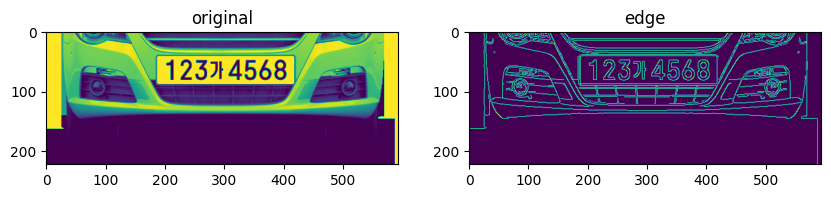

In [3]:
#에지 검출
edge = cv2.Canny(image, 50, 150)
fig, ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(image)
ax[0].set_title('original')
ax[1].imshow(edge)
ax[1].set_title('edge')

Text(0.5, 1.0, 'morphology')

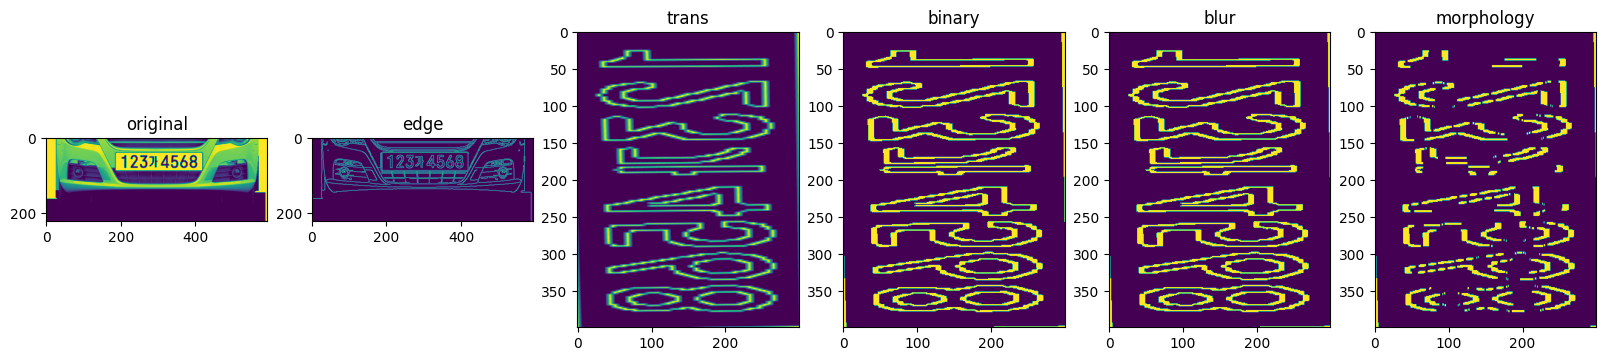

In [4]:
#투시변환
#입력 영상으로 사용한 번호판의 외곽선은 크기가 가장 큰 4개의 외곽선으로 이루어져 있다는 점을 이용해 외곽선을 크기순으로 정렬

contours = cv2.findContours(edge.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]  # 외곽선 크기순으로 정렬

for i in contours:
    length = cv2.arcLength(i, True)
    approx = cv2.approxPolyDP(i, 0.02 * length, True)

    if len(approx) == 4: #번호판의 외곽선은 4개로 이뤄져 있어서
        contourCnt = approx
        break

# 투시변환
image_pts = np.array([[approx[0][0][0], approx[0][0][1]],
                    [approx[1][0][0], approx[1][0][1]],
                    [approx[2][0][0], approx[2][0][1]],
                    [approx[3][0][0], approx[3][0][1]]]).astype(np.float32)

w = 300
h = 400

dst_pts = np.array([[0, 0],
                    [0, h - 1],
                    [w - 1, h - 1],
                    [w - 1, 0]]).astype(np.float32)

pers_mat = cv2.getPerspectiveTransform(image_pts, dst_pts)
image_transform = cv2.warpPerspective(edge, pers_mat, (w, h))

#이진화
_, image_binary = cv2.threshold(image_transform, 0, 255, cv2.THRESH_OTSU)

#노이즈 제거(이거 아마 가우시안 해도 될 듯)
image_filtering = cv2.bilateralFilter(image_binary, -1, 10, 5)

#모폴로지 연산
kernel = np.ones((3, 1), np.uint8)
image_morphology = cv2.morphologyEx(image_filtering, cv2.MORPH_OPEN, kernel)

fig, ax = plt.subplots(1,6,figsize=(20,18))
ax[0].imshow(image)
ax[0].set_title('original')
ax[1].imshow(edge)
ax[1].set_title('edge')
ax[2].imshow(image_transform)
ax[2].set_title('trans')
ax[3].imshow(image_binary)
ax[3].set_title('binary')
ax[4].imshow(image_filtering)
ax[4].set_title('blur')
ax[5].imshow(image_morphology)
ax[5].set_title('morphology')

In [10]:
%pip install pytesseract==0.3.9


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [14]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
config = ('-l kor --oem 0 --psm 7')
text = pytesseract.image_to_string(image_transform, config=config)
print('==========텍스트 인식 결과==========')
print(text)

==========텍스트 인식 결과==========
) 흐흐)

